# PartiAlg (v0.1) Tutorial

A package for partialization of algebraic operations, including partial inversion, block-diagonalization and applications.

Cite to attribute the author for using or extending functions related to partial inversion:
    
    Dennis Lima and Saif Al-Kuwari 2024 Phys. Scr. 99 045202. URL: https://doi.org/10.1088/1402-4896/ad298a 

---
🌱 Save the environment, sleep on compassion, mind your health — make today your vegan day.

### Example 1 - Symbolic partial inversion

In [23]:
from partialg.symbolic.inversion import pinv
import sympy as sy
import numpy as np

s = sy.symbols('a b c d e f g h i')
s = sy.reshape(s, [3,])
s = np.array(s)
s
V = pinv(s, (1,2) )
sy.simplify(V)

Matrix([
[ a - c*d/f,  b - c*e/f, c/f],
[      -d/f,       -e/f, 1/f],
[-d*i/f + g, -e*i/f + h, i/f]])

### Example 2 - Partial Inversion as identity operation

In [21]:
import numpy as np
from partialg.dense.inversion import pinv

M  = np.random.rand(5,5)
M2 = pinv(M, (1,2), (2,2), (2,2), (1,2)  )

# Result must be zero.
np.round( M2 - M, 6)

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -0.,  0.],
       [ 0.,  0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -0., -0.]])

### Example 3 - Partial Inversion-Permutation Equivalence
Eq. 44 from [original paper](https://www.doi.org/10.1088/1402-4896/ad298a).

In [20]:
import numpy as np
from partialg.dense.inversion import pinv

M  = np.random.rand(2, 2)
M2 = pinv(M, (1,0), (0,0), (0,1), (0,0), (1,1))
X  = np.array([[0,1],[1,0]])

# Result must be zero.
np.round( (M @ X ) - M2, 6)

array([[-0.,  0.],
       [-0.,  0.]])

### Example 4 - Partial Inversion and conservation of path (of a graph)
This example shows how the partial inversion-index permutation equivalence allows us to obtain the same partially-inverted transfer matrix T from different sequences of partial inversions and matrix products, as long as the path along their auxiliary graphs lead to the same node.

In this example, the graph path grows either first horizontally then vertically, or first vertically then horizontally.

Demonstration of Fig. 3 from [original paper](https://www.doi.org/10.1088/1402-4896/ad298a).

In [18]:
import numpy as np
from partialg.dense.inversion import pinv

# S can be any unitary matrix.
S = np.sqrt(2) * np.array([[1,1],[-1,1]])
T = pinv(S, (1,1))
A = pinv(T, (1,0))

# Left-hand side of equation
T42   = pinv( A @ A @ A, (1,0) )
T44_l = T42 @ T42 @ T42

# Right-hand side of equation
A24 = pinv( T @ T @ T,       (1,0) )
T44_r = pinv( A24 @ A24 @ A24, (1,0) )

# Result must be zero.
np.round( T44_l - T44_r, 6)

array([[0., 0.],
       [0., 0.]])

### Example 5 - Partial Inversion and kha-guna expressions 

Consider the hypothesis that partial inversion along the main diagonal of an invertible, sparse matrix will always return the matrix inverse in the original space where the matrix is defined.

If the matrix is fully symbolic, this is easily verified by substituting the variables at the end of the symbolic inversion, regardless of whether the variables are zero or not under inversion. Thus, by treating zero as a special base (kha-guna), one can derive the kha-guna simplification rules from inversion by partial inversion.

The inversion of the (2,2)-size permutation matrix with symbolic 'o' in place of zeros, followed by realization into zero, is the simplest example. 

Note: As kha-guna expressions are not explicitly complex (or real), the priorities of simplification rules are also not explicitly the same as those of an arbitrary non-zero complex variable, therefore $\texttt{sympy}$ symbols may fail for larger expressions.

Demonstration of application of [original paper](https://www.doi.org/10.1088/1402-4896/ad298a).

In [13]:
import sympy as sy
from partialg.symbolic.inversion import pinv

# Defining kha-guna as a variable that represents zero
o       = sy.symbols('o') 

# Defining the Pauli matrix X with kha-gunas in place of zeros
Xkh     = np.array([[o,1],[1,o]])
Xkh_inv = pinv(Xkh, (0,0), (1,1))  # Full matrix inversion

# See before simplification
Xkh_inv

Matrix([
[1/o + 1/(o**2*(o - 1/o)), -1/(o*(o - 1/o))],
[        -1/(o*(o - 1/o)),      1/(o - 1/o)]])

In [14]:
# See after simplification
Xkh_inv_ = sy.simplify(Xkh_inv)
Xkh_inv_

Matrix([
[ o/(o**2 - 1), -1/(o**2 - 1)],
[-1/(o**2 - 1),  o/(o**2 - 1)]])

In [15]:
# See after substitution of kha-guna by zero (realization)
Xkh_inv_rep = Xkh_inv_.replace(o, 0)
Xkh_inv_rep

# (!) Attention: sympy.simplify is not equipped... 
# for the manipulation of arbitrary kha-guna   ...
# polynomials. So some simplifications using   ...
# sympy.simplify may fail.

Matrix([
[0, 1],
[1, 0]])

### Example 6 - Error of Sridhara Block Diagonalization given N, T

Due to the limitations of the Newton-Schulz expansion, the error distribution can be minimized for an eigenvalue space. By default, we should force the space to within $[0,1]$ prior to eigensolving, and then recover the eigenvalues using the inverse operations. That's why one must define the translation factor $T$ and the scale factor $N$ appropriately.

In this example, we obtain the absolute error distribution, mean absolute error and absolute error standard deviation $\sigma$ of the smallest eigenvalue (ground state) after full compression of a population of random matrices at a fixed size. 

The routine is:
1. The matrix of arbitrary eigenvalues is eigensolved to find its ground and top states, then it is normalized and translated to have its spectrum exactly within the domain $[T, N+T]$. 
2. Next, the transformed matrix is compressed using the choice of $\texttt{block\_eigensolver}$, and multiplied by its adjoint to restore Hermiticity. 
3. The new Hermitian matrix is eigensolved for the smallest eigenvalue, and this eigenvalue undergoes square root and all the inverse operations to recover the original eigenvalue. 
4. Finally, the error is computed between this recovered eigenvalue and the one obtained from eigensolving the original, uncompressed matrix.

In real problems where the eigenvalues are unknown, $N$ and $T$ must be guessed to approach the transformed ground state to zero to minimize the error.

Warning: The Arnoldi eigensolver (default in scipy.sparse.linalg.eigs) may give errors for singular matrices, so if you wanna set T as zero, you should use a small number close to zero instead, like 0.001.

C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  Ainv = spsolve(A, I)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Mean error: 0.012756196791054697
Standard deviation: 0.01202413448611116


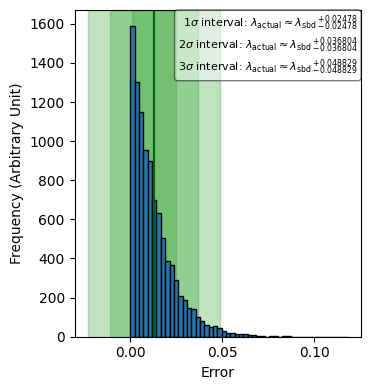

In [2]:
from partialg.sparse.compression import SBD_eigenleaf
from partialg.sparse.statistics import SBDError, SBDErrorPlot

sample_size = 10000
report      = SBDError((16,16), sample_size=sample_size, block_eigensolver= SBD_eigenleaf, T=0.001, N=1)

print('Mean error:', report['mean_error'])
print('Standard deviation:', report['error_std'])


SBDErrorPlot(report, saveas='sparse_randommatrix10000')

### Example 7 - SBD Eigenbranch

In this example we obtain all the Hamiltonians along a branch of the binary tree that represents the compression path, by specifying the block_index.

🌳 At each compression step, '0' chooses the smaller-magnitude block, whereas '1' chooses the larger-magnitude block to proceed along the compression branch. This way, the global ground state for a $2^4$-sized matrix is at '0000', the next eigenvalue is at '0001', and so on, till the largest eigenvalue at '1111'.

In [11]:
from partialg.dense.compression import SBD_eigbranch
# Quality correction factors
T0 = 0
N0 = 1

# Preparing Hermitian matrix
M = np.random.rand(8,8)                # Generating random matrix M
M = M.dot(M.T.conjugate() )  # Making M Hermitian
M = M/np.trace(M)/N0 + T0*np.eye(8)    # Normalizing M

# Generating branch of block-eigenvalues.
block_eigenvalue_branch = SBD_eigbranch(M, block_index='000', )
block_eigenvalue_branch

([array([[0.13644829, 0.05149846, 0.06731787, 0.06699839, 0.08108265,
          0.09885065, 0.07880833, 0.09343369],
         [0.05149846, 0.04352896, 0.07077054, 0.05160511, 0.07313783,
          0.07697397, 0.05973804, 0.06893644],
         [0.06731787, 0.07077054, 0.16893116, 0.08884405, 0.13478512,
          0.14030043, 0.08409314, 0.10493945],
         [0.06699839, 0.05160511, 0.08884405, 0.09094385, 0.0992541 ,
          0.10578912, 0.06589113, 0.10175667],
         [0.08108265, 0.07313783, 0.13478512, 0.0992541 , 0.15103182,
          0.14394689, 0.11315717, 0.11994003],
         [0.09885065, 0.07697397, 0.14030043, 0.10578912, 0.14394689,
          0.15753511, 0.1136615 , 0.12813328],
         [0.07880833, 0.05973804, 0.08409314, 0.06589113, 0.11315717,
          0.1136615 , 0.11442574, 0.09865946],
         [0.09343369, 0.06893644, 0.10493945, 0.10175667, 0.11994003,
          0.12813328, 0.09865946, 0.13715507]]),
  array([[ 0.01388228, -0.0015833 ,  0.01480416, -0.01314429],

### Example 8 - SBD-VQE of tetracene with pennylane

Time: about 20 min.

⚛️ Tetracene ($\mathrm{C}_{18}\mathrm{H}_{12}$, CID 7080) is a tetracyclic aromatic compound used in some OLEDs and transistors.
In this example, we estimate its ground state using the SBD compression prior to eigensolving, for different compression rates. Next, we plot the error with regard to the uncompressed-LU eigensolver to visualize how the error decreases quite fast for the VQE, while the first few compressions show good agreement with the results of the uncompressed VQE.

👶🏻 The Hamiltonian was generated using DFT with B3LYP functional and STO-3G basis set, considering a (6e, 6o) active space (6 active electrons and 6 active orbitals), for demonstration only, as more realistic models would be too heavy for a demonstration.

This example requires the packages $\texttt{pennylane}$ and $\texttt{qiskit}$, but not $\texttt{pyscf}$, as the Hamiltonian was computed previously.

In [ ]:
# Loading Hamiltonian

import numpy as np
from matplotlib import pyplot as plt                     # For data visualization
import scipy as sp

from qiskit.quantum_info import SparsePauliOp, Operator    # Used to convert sparse Hamiltonian into Operator

import pennylane as qml
import optax
import jax

import time
import pickle
from tqdm import tqdm                                    # To track progress

from partialg.sparse.compression import SBD_eigbranch


# Load Hamiltonian from pickled dictionary.
with open('partialg/database/a1_66.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
# May take about 1 minute

# Compressing Hamiltonian

# Loading qchem Hamiltonian as scipy sparse matrix
branch, report = SBD_eigbranch( data['H'].sparse_matrix(), block_index = '0'*(data['qubits']-2) , only_even=True  )

print(f"Compression time (s): {report['time']}")
print(f"Marix sizes (qubit): {[ int(np.log2(i.shape[0])) for i in branch ]}")


C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  Ainv = spsolve(A, I)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Compression time (s): [0, 0.39799664666643364, 0.41252484666765665, 0.4154050216660835, 0.4161746800004039, 0.4164930983330123]
Marix sizes (qubit): [12, 10, 8, 6, 4, 2]


In [4]:
# May take 2 minutes.

# Classical eigensolver
reference_evs = np.real( [ min(np.linalg.eigvals( i.toarray() )) for i in branch ] )

print(reference_evs)

[-631.55718821 -631.55725069 -631.55733434 -631.56287322 -631.62866175
 -631.62907083]


Variational Quantum Eigensolver using pennylane

In [5]:
# May take about 4 min.

T0 = 0
N0 = 1

# VQE ----------------------------------------------
def sparse_to_pennylane(ham):
    L0o           = Operator( ham.toarray() )
    L0q_qiskit    = np.array( SparsePauliOp.from_operator(L0o).to_list(), dtype='object' )
    coeffs        = np.real( L0q_qiskit[:, 1])
    pauli_strings = L0q_qiskit[:, 0]
    #
    observables = []
    for pauli_str in pauli_strings:
        ops         = []
        for wire, pauli in enumerate(pauli_str):
            if pauli == "I":
                continue  # Identity does not need to be applied
            elif pauli == "X":
                ops.append(qml.PauliX(wire))
            elif pauli == "Y":
                ops.append(qml.PauliY(wire))
            elif pauli == "Z":
                ops.append(qml.PauliZ(wire))
        #
        if len(ops) == 0:
            # Pure identity term: PennyLane expects Identity(wire)
            observables.append(qml.Identity(0))
        else:
            term_op = ops[0]
            for op_ in ops[1:]:
                term_op = term_op @ op_
            observables.append(term_op)
    #
    print(len(coeffs))
    print(observables)
    H = qml.Hamiltonian(coeffs, observables)
    #
    #
    #L0q = qml.Hamiltonian(coeffs, pauli_strings)
    return H


vqe_evs = []
for k, i in tqdm( enumerate(branch) ):
    # Compressing eigenstate
    hf_state = data['hf_state']
    hf_state_compressed = hf_state[ : int(np.log2(i.shape[0]) ) ] # Manual compression
    #
    # Loading scipy sparse matrix as qchem Hamiltonian
    H_pen = sparse_to_pennylane(i)
    #
    dev       = qml.device("lightning.qubit", wires= H_pen.wires )
    #
    q         = np.sort( H_pen.wires )
    occupied  = q[ :int(len(q)/2) ]
    available = q[int(len(q)/2): ]
    def generate_angles():
        angles = []
        for o in occupied[::-1][::2]:
            for a in available[::2]:
                angles.append(0.)
        for o in occupied[::-1][::2]:
            for a in available[::2]:
                angles.append(0.)
        return angles

    #
    angles = []
    @qml.qnode(dev, interface="jax")
    def circuit(param, hf_state, wires):
        qml.BasisState(hf_state, wires=wires)                
        for o in occupied[::-1][:-1]:
            for a in available[:-1]:
                qml.SingleExcitation(param, wires= [o, a] )
        for o in occupied[::-1][:-1]:
            for a in available[:-1]:
                qml.DoubleExcitation(param, wires= [o, o-1] + [a, a+1] )
                #
        return qml.expval(H_pen)
    #
    def cost_fn(param):
        return circuit(param, hf_state=hf_state_compressed, wires= H_pen.wires)
    #
    max_iterations = 100
    conv_tol       = 1e-12
    opt            = optax.sgd(learning_rate=0.4)
    #theta         = np.array( generate_angles() )
    #theta          = np.array([0.,])
    theta = 0.
    #
    # store the values of the cost function
    energy         = [ cost_fn(theta) ]
    #
    # store the values of the circuit parameter
    angle          = [theta]
    #
    opt_state = opt.init(theta)
    #
    steps    = []
    energies = []
    t0 = time.perf_counter()
    for n in range(max_iterations):
        #
        gradient = jax.grad(cost_fn)(theta)
        updates, opt_state = opt.update(gradient, opt_state)
        theta = optax.apply_updates(theta, updates)

        angle.append(theta)
        energy.append(cost_fn(theta))

        conv = np.abs(energy[-1] - energy[-2])

        #if n % 2 == 0:
        #print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")
        steps.append(n)
        energies.append( energy[-1]) #-np.real( np.sqrt( np.abs( (energy[-1]-T0)*N0 ) ) ) )
        #
        if conv <= conv_tol:
            break
    vqe_evs.append(energies[0] )

0it [00:00, ?it/s]

367
[I(0), Z(11), Z(10), Z(10) @ Z(11), Z(9), Z(9) @ Z(11), Z(9) @ Z(10), X(8) @ X(9) @ Y(10) @ Y(11), X(8) @ Y(9) @ Y(10) @ X(11), Y(8) @ X(9) @ X(10) @ Y(11), Y(8) @ Y(9) @ X(10) @ X(11), Z(8), Z(8) @ Z(11), Z(8) @ Z(10), Z(8) @ Z(9), X(7) @ Z(8) @ Z(9) @ Z(10) @ X(11), Y(7) @ Z(8) @ Z(9) @ Z(10) @ Y(11), Z(7), Z(7) @ Z(11), Z(7) @ Z(10), Z(7) @ X(9) @ Z(10) @ X(11), Z(7) @ Y(9) @ Z(10) @ Y(11), Z(7) @ Z(9), Z(7) @ Z(8), X(6) @ X(7) @ Y(10) @ Y(11), X(6) @ X(7) @ X(9) @ X(10), X(6) @ X(7) @ Y(8) @ Y(9), X(6) @ X(7) @ Y(8) @ Z(9) @ Z(10) @ Y(11), X(6) @ Y(7) @ Y(10) @ X(11), X(6) @ Y(7) @ Y(9) @ X(10), X(6) @ Y(7) @ Y(8) @ X(9), X(6) @ Y(7) @ Y(8) @ Z(9) @ Z(10) @ X(11), X(6) @ Z(7) @ Z(8) @ Z(9) @ X(10), Y(6) @ X(7) @ X(10) @ Y(11), Y(6) @ X(7) @ X(9) @ Y(10), Y(6) @ X(7) @ X(8) @ Y(9), Y(6) @ X(7) @ X(8) @ Z(9) @ Z(10) @ Y(11), Y(6) @ Y(7) @ X(10) @ X(11), Y(6) @ Y(7) @ Y(9) @ Y(10), Y(6) @ Y(7) @ X(8) @ X(9), Y(6) @ Y(7) @ X(8) @ Z(9) @ Z(10) @ X(11), Y(6) @ Z(7) @ Z(8) @ Z(9) @ Y(

C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

7248
[I(0), Z(9), Z(8), Z(8) @ Z(9), Z(7), Z(7) @ Z(9), Z(7) @ Z(8), Z(7) @ Z(8) @ Z(9), X(6) @ X(7) @ X(8) @ Y(9), X(6) @ X(7) @ Y(8) @ X(9), X(6) @ X(7) @ Y(8) @ Y(9), X(6) @ Y(7) @ X(8) @ X(9), X(6) @ Y(7) @ Y(8) @ X(9), X(6) @ Y(7) @ Y(8) @ Y(9), Y(6) @ X(7) @ X(8) @ X(9), Y(6) @ X(7) @ X(8) @ Y(9), Y(6) @ X(7) @ Y(8) @ Y(9), Y(6) @ Y(7) @ X(8) @ X(9), Y(6) @ Y(7) @ X(8) @ Y(9), Y(6) @ Y(7) @ Y(8) @ X(9), Z(6), Z(6) @ Z(9), Z(6) @ Z(8), Z(6) @ Z(8) @ Z(9), Z(6) @ Z(7), Z(6) @ Z(7) @ Z(9), Z(6) @ Z(7) @ Z(8), Z(6) @ Z(7) @ Z(8) @ Z(9), X(5) @ Z(7) @ Z(8) @ X(9), X(5) @ Z(6) @ Z(8) @ X(9), X(5) @ Z(6) @ Z(7) @ X(9), X(5) @ Z(6) @ Z(7) @ Z(8) @ X(9), X(5) @ Z(6) @ Z(7) @ Z(8) @ Y(9), Y(5) @ Z(7) @ Z(8) @ Y(9), Y(5) @ Z(6) @ Z(8) @ Y(9), Y(5) @ Z(6) @ Z(7) @ Y(9), Y(5) @ Z(6) @ Z(7) @ Z(8) @ X(9), Y(5) @ Z(6) @ Z(7) @ Z(8) @ Y(9), Z(5), Z(5) @ Z(9), Z(5) @ Z(8), Z(5) @ Z(8) @ Z(9), Z(5) @ X(7) @ Z(8) @ X(9), Z(5) @ Y(7) @ Z(8) @ Y(9), Z(5) @ Z(7), Z(5) @ Z(7) @ Z(9), Z(5) @ Z(7) @ Z(8)

C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

8907
[I(0), Z(7), Z(6), Z(6) @ Z(7), Z(5), Z(5) @ Z(7), Z(5) @ Z(6), Z(5) @ Z(6) @ Z(7), X(4) @ X(6) @ Z(7), X(4) @ X(5) @ X(6) @ X(7), X(4) @ X(5) @ X(6) @ Y(7), X(4) @ X(5) @ Y(6) @ X(7), X(4) @ X(5) @ Y(6) @ Y(7), X(4) @ Y(5) @ X(6) @ X(7), X(4) @ Y(5) @ X(6) @ Y(7), X(4) @ Y(5) @ Y(6) @ X(7), X(4) @ Y(5) @ Y(6) @ Y(7), Y(4) @ Y(6) @ Z(7), Y(4) @ X(5) @ X(6) @ X(7), Y(4) @ X(5) @ X(6) @ Y(7), Y(4) @ X(5) @ Y(6) @ X(7), Y(4) @ X(5) @ Y(6) @ Y(7), Y(4) @ Y(5) @ X(6) @ X(7), Y(4) @ Y(5) @ X(6) @ Y(7), Y(4) @ Y(5) @ Y(6) @ X(7), Y(4) @ Y(5) @ Y(6) @ Y(7), Z(4), Z(4) @ Z(7), Z(4) @ Z(6), Z(4) @ Z(6) @ Z(7), Z(4) @ Z(5), Z(4) @ Z(5) @ Z(7), Z(4) @ Z(5) @ Z(6), Z(4) @ Z(5) @ Z(6) @ Z(7), X(3) @ X(7), X(3) @ Y(7), X(3) @ Z(6) @ X(7), X(3) @ Z(6) @ Y(7), X(3) @ X(5), X(3) @ X(5) @ Z(6) @ Z(7), X(3) @ Z(5) @ X(7), X(3) @ Z(5) @ Y(7), X(3) @ Z(5) @ Z(6) @ X(7), X(3) @ Z(5) @ Z(6) @ Y(7), X(3) @ X(4) @ X(6) @ X(7), X(3) @ X(4) @ X(5) @ X(6), X(3) @ X(4) @ X(5) @ X(6) @ Z(7), X(3) @ X(4) @ Y(5) 

C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

1016
[I(0), Z(5), Z(4), Z(4) @ Z(5), X(3) @ X(5), X(3) @ Y(5), X(3) @ Z(4) @ X(5), X(3) @ Z(4) @ Y(5), Y(3) @ X(5), Y(3) @ Y(5), Y(3) @ Z(4) @ X(5), Y(3) @ Z(4) @ Y(5), Z(3), Z(3) @ Z(5), Z(3) @ Z(4), Z(3) @ Z(4) @ Z(5), X(2) @ X(4), X(2) @ X(4) @ Z(5), X(2) @ Y(4), X(2) @ Y(4) @ Z(5), X(2) @ X(3) @ X(4) @ X(5), X(2) @ X(3) @ X(4) @ Y(5), X(2) @ X(3) @ Y(4) @ X(5), X(2) @ X(3) @ Y(4) @ Y(5), X(2) @ Y(3) @ X(4) @ X(5), X(2) @ Y(3) @ X(4) @ Y(5), X(2) @ Y(3) @ Y(4) @ X(5), X(2) @ Y(3) @ Y(4) @ Y(5), X(2) @ Z(3) @ X(4), X(2) @ Z(3) @ X(4) @ Z(5), X(2) @ Z(3) @ Y(4), X(2) @ Z(3) @ Y(4) @ Z(5), Y(2) @ X(4), Y(2) @ X(4) @ Z(5), Y(2) @ Y(4), Y(2) @ Y(4) @ Z(5), Y(2) @ X(3) @ X(4) @ X(5), Y(2) @ X(3) @ X(4) @ Y(5), Y(2) @ X(3) @ Y(4) @ X(5), Y(2) @ X(3) @ Y(4) @ Y(5), Y(2) @ Y(3) @ X(4) @ X(5), Y(2) @ Y(3) @ X(4) @ Y(5), Y(2) @ Y(3) @ Y(4) @ X(5), Y(2) @ Y(3) @ Y(4) @ Y(5), Y(2) @ Z(3) @ X(4), Y(2) @ Z(3) @ X(4) @ Z(5), Y(2) @ Z(3) @ Y(4), Y(2) @ Z(3) @ Y(4) @ Z(5), Z(2), Z(2) @ Z(5), Z(2) @ Z

C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
4it [02:20, 31.84s/it]C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
5it [02:20, 20.40s/it]C:\Users\der70\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pennylane_lightning\core\_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
6it [02:20, 23.42s/it]

64
[I(0), Z(3), Z(2), Z(2) @ Z(3), X(1) @ X(3), X(1) @ Y(3), X(1) @ Z(2) @ X(3), X(1) @ Z(2) @ Y(3), Y(1) @ X(3), Y(1) @ Y(3), Y(1) @ Z(2) @ X(3), Y(1) @ Z(2) @ Y(3), Z(1), Z(1) @ Z(3), Z(1) @ Z(2), Z(1) @ Z(2) @ Z(3), X(0) @ X(2), X(0) @ X(2) @ Z(3), X(0) @ Y(2), X(0) @ Y(2) @ Z(3), X(0) @ X(1) @ X(2) @ X(3), X(0) @ X(1) @ X(2) @ Y(3), X(0) @ X(1) @ Y(2) @ X(3), X(0) @ X(1) @ Y(2) @ Y(3), X(0) @ Y(1) @ X(2) @ X(3), X(0) @ Y(1) @ X(2) @ Y(3), X(0) @ Y(1) @ Y(2) @ X(3), X(0) @ Y(1) @ Y(2) @ Y(3), X(0) @ Z(1) @ X(2), X(0) @ Z(1) @ X(2) @ Z(3), X(0) @ Z(1) @ Y(2), X(0) @ Z(1) @ Y(2) @ Z(3), Y(0) @ X(2), Y(0) @ X(2) @ Z(3), Y(0) @ Y(2), Y(0) @ Y(2) @ Z(3), Y(0) @ X(1) @ X(2) @ X(3), Y(0) @ X(1) @ X(2) @ Y(3), Y(0) @ X(1) @ Y(2) @ X(3), Y(0) @ X(1) @ Y(2) @ Y(3), Y(0) @ Y(1) @ X(2) @ X(3), Y(0) @ Y(1) @ X(2) @ Y(3), Y(0) @ Y(1) @ Y(2) @ X(3), Y(0) @ Y(1) @ Y(2) @ Y(3), Y(0) @ Z(1) @ X(2), Y(0) @ Z(1) @ X(2) @ Z(3), Y(0) @ Z(1) @ Y(2), Y(0) @ Z(1) @ Y(2) @ Z(3), Z(0), Z(0) @ Z(3), Z(0) @ Z(2

Plotting data

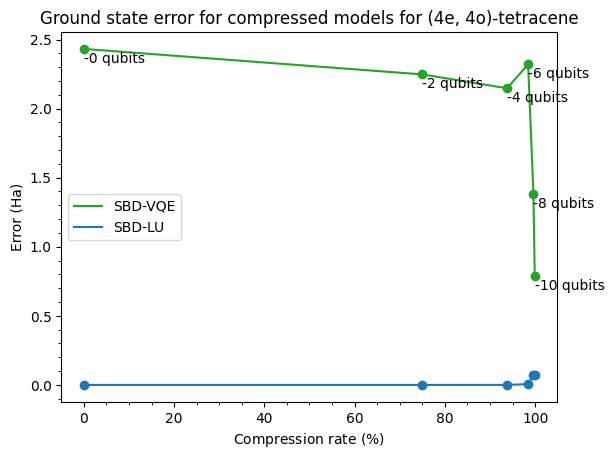

In [6]:

y1 = np.abs( vqe_evs - reference_evs[0] )
y2 = np.abs( reference_evs - reference_evs[0] )

x1 = 100*(1 - 2.**(-2.*np.arange(len(y1))) )
x2 = 100*(1- 2.**(-2.*np.arange(len(y2))) )

fig, ax = plt.subplots()

ax.plot( x1, y1, color='tab:green', label='SBD-VQE')
ax.plot( x2, y2, color='tab:blue', label='SBD-LU')
ax.scatter(x1, y1, color='tab:green')
ax.scatter(x2, y2, color='tab:blue')

for x, y, k in zip(x1, y1, range(len(x1))):
    plt.text(x, y-0.1, s=f'-{2*k} qubits', color='k')

ax.set_title('Ground state error for compressed models for (4e, 4o)-tetracene')

ax.minorticks_on()
ax.set_xlabel('Compression rate $(\%)$')
ax.set_ylabel('Error (Ha)')


plt.legend()
plt.show()